# Comparaison des Modèles YOLO

Ce notebook permet de charger les résultats de validation des différents modèles YOLO (v8, v10, v11) et de générer des graphiques de comparaison pour le mémoire.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import numpy as np
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# Configuration du style pour des graphiques scientifiques
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## Chargement des Données

Nous allons lire tous les fichiers CSV du dossier courant et extraire les informations pertinentes.

In [2]:
def parse_filename(filename):
    """Extract model info from filename."""
    # Normalisation du nom de fichier pour gérer les typos et variations
    name = os.path.basename(filename).replace('.csv', '')
    
    # Regex pour capturer la version, la taille et si c'est pré-entraîné
    # Exemples: yolov11s.csv, yolov11s-petrain.csv, yolov8m_pretrain.csv
    match = re.search(r'(yolov\d+)([sm])', name)
    
    if match:
        version = match.group(1).upper() # ex: YOLOV11
        size = match.group(2).upper()    # ex: S
        model_name = f"{version}{size}"
    else:
        model_name = name
        version = "Unknown"
        size = "Unknown"
    
    # Détection du pré-entraînement
    is_pretrained = 'pretrain' in name or 'petrain' in name
    training_type = "Pretrained" if is_pretrained else "Scratch"
    
    return model_name, version, size, training_type

data = []
csv_files = glob.glob("*.csv")
csv_files = [f for f in csv_files if not f.endswith("all_results.csv")]

print(csv_files)

for file in csv_files:
    try:
        df = pd.read_csv(file)
        model_name, version, size, training_type = parse_filename(file)

        # On garde toutes les lignes (un test par dataset + global)
        for _, row in df.iterrows():
            data.append({
                "Model": model_name,
                "Version": version,
                "Size": size,
                "Training": training_type,
                "Source": row.get("source", "Unknown"),

                "mAP50-95": row.get("map50_95_mean", 0),
                "mAP50": row.get("map50_mean", 0),
                "mAP75": row.get("map75_mean", 0),
                "Precision": row.get("precision_mean", 0),
                "Recall": row.get("recall_mean", 0),
                "F1": row.get("f1_mean", 0),
                "Inference Time (ms)": row.get("speed_inf_ms_mean", 0),
                "Preprocessing Time (ms)": row.get("speed_pre_ms_mean", 0),
                "Postprocessing Time (ms)": row.get("speed_post_ms_mean", 0),
                "Total Time (ms)": row.get("speed_total_ms_mean", 0),
                "FPS": row.get("fps_est_mean", 0),
            })
    except Exception as e:
        print(f"Erreur lors de la lecture de {file}: {e}")

results_df = pd.DataFrame(data)

# =========================
# 2) Extraire le % de background
# =========================

def extract_background_percentage(model_name: str):
    """
    Retourne le pourcentage de background à partir du nom du modèle.
    - 'background5', 'background10_seed2', ... -> 5, 10, ...
    - 'aug' -> 0 (référence sans background)
    """
    model_name = str(model_name)

    m = re.search(r"background(\d+)", model_name)
    if m:
        return int(m.group(1))

    if "aug" in model_name:
        return 0

    return np.nan

results_df["Background_%"] = results_df["Model"].apply(extract_background_percentage)

# =========================
# 3) Agrégation (moyenne + variance)
# =========================

metrics_cols = [
    "mAP50-95",
    "mAP50",
    "mAP75",
    "Precision",
    "Recall",
    "F1",
    "Inference Time (ms)",
    "Preprocessing Time (ms)",
    "Postprocessing Time (ms)",
    "Total Time (ms)",
    "FPS",
]

# On enlève les lignes sans pourcentage (si jamais)
df_for_stats = results_df.dropna(subset=["Background_%"])

# GroupBy par pourcentage de background ET par dataset (Source)
agg_df = (
    df_for_stats
    .groupby(["Background_%", "Source"])[metrics_cols]
    .agg(["mean", "var"])      # moyenne + variance sur les seeds
    .reset_index()
)

# Aplatir les colonnes MultiIndex
agg_df.columns = (
    ["Background_%", "Source"] +
    [f"{metric}_{stat}" for metric in metrics_cols for stat in ["mean", "var"]]
)

# Tri pour lisibilité
agg_df = agg_df.sort_values(["Background_%", "Source"])

# Sauvegarde optionnelle
agg_df.to_csv("background_agg_results_by_dataset.csv", index=False)

agg_df.head(100)



['aug.csv', 'background10.csv', 'background20.csv', 'background30.csv', 'background5.csv', 'background5_seed2.csv', 'background5_seed3.csv', 'background10_seed2.csv', 'background10_seed3.csv', 'background20_seed2.csv', 'background20_seed3.csv', 'background30_seed2.csv', 'background30_seed3.csv', 'background_agg_results.csv', 'background_agg_results_by_dataset.csv', 'aug2.csv', 'aug1.csv']


,Background_%,Source,mAP50-95_mean,mAP50-95_var,mAP50_mean,mAP50_var,mAP75_mean,mAP75_var,Precision_mean,Precision_var,...,Inference Time (ms)_mean,Inference Time (ms)_var,Preprocessing Time (ms)_mean,Preprocessing Time (ms)_var,Postprocessing Time (ms)_mean,Postprocessing Time (ms)_var,Total Time (ms)_mean,Total Time (ms)_var,FPS_mean,FPS_var
0,0.0,TestSet::dataset::datamatrix140,0.306632,NaN,0.771544,NaN,0.191722,NaN,0.842951,NaN,...,26.421956,NaN,0.699905,NaN,6.917082,NaN,34.038942,NaN,29.378116,NaN
1,0.0,TestSet::dataset::datamatrixfit,0.328712,0.000006,0.709984,0.003113,0.235693,0.001360,0.805925,0.000169,...,18.121746,29.533647,2.171089,0.015194,3.072777,0.000218,23.365612,31.053061,44.273570,86.136733
2,0.0,TestSet::dataset::dmcode,0.613501,NaN,0.907100,NaN,0.681546,NaN,0.946923,NaN,...,20.471739,NaN,0.682830,NaN,2.428466,NaN,23.583035,NaN,42.403363,NaN
3,0.0,TestSet::dataset::implementacao,0.563921,NaN,0.912828,NaN,0.597736,NaN,0.989141,NaN,...,22.842321,NaN,2.302988,NaN,2.392818,NaN,27.538126,NaN,36.313291,NaN
4,0.0,TestSet::dataset::pcbdataset,0.511275,0.000048,0.808765,0.000264,0.572156,0.000342,0.853928,0.003274,...,15.686298,32.111649,1.327594,0.014887,0.854744,1.649716,17.868637,50.029287,61.164680,388.387342
5,0.0,TestSet::dataset::qrv2,0.682504,NaN,0.967456,NaN,0.796481,NaN,0.980166,NaN,...,20.140710,NaN,0.548299,NaN,2.224363,NaN,22.913371,NaN,43.642640,NaN
6,0.0,TestSet::dataset::real2dcodes,0.635857,NaN,0.969154,NaN,0.859433,NaN,0.990659,NaN,...,20.243737,NaN,0.808351,NaN,2.249863,NaN,23.301951,NaN,42.914862,NaN
7,0.0,TestSet::dataset::recntagledmtest,0.306603,NaN,0.917393,NaN,0.071907,NaN,0.811142,NaN,...,20.400129,NaN,0.647445,NaN,2.273305,NaN,23.320879,NaN,42.880031,NaN
8,0.0,TestSet::global::global,0.384738,0.001115,0.830041,0.000646,0.299211,0.002021,0.859384,0.000192,...,12.122206,47.309860,0.310858,0.038773,0.845920,1.470497,13.278984,68.687045,93.075012,1823.545849
9,5.0,TestSet::dataset::datamatrix140,0.382069,0.002044,0.827220,0.000372,0.304285,0.006011,0.879698,0.001245,...,16.485253,11.578356,0.574896,0.010483,6.064946,3.248033,23.125094,27.957981,44.644287,84.949032


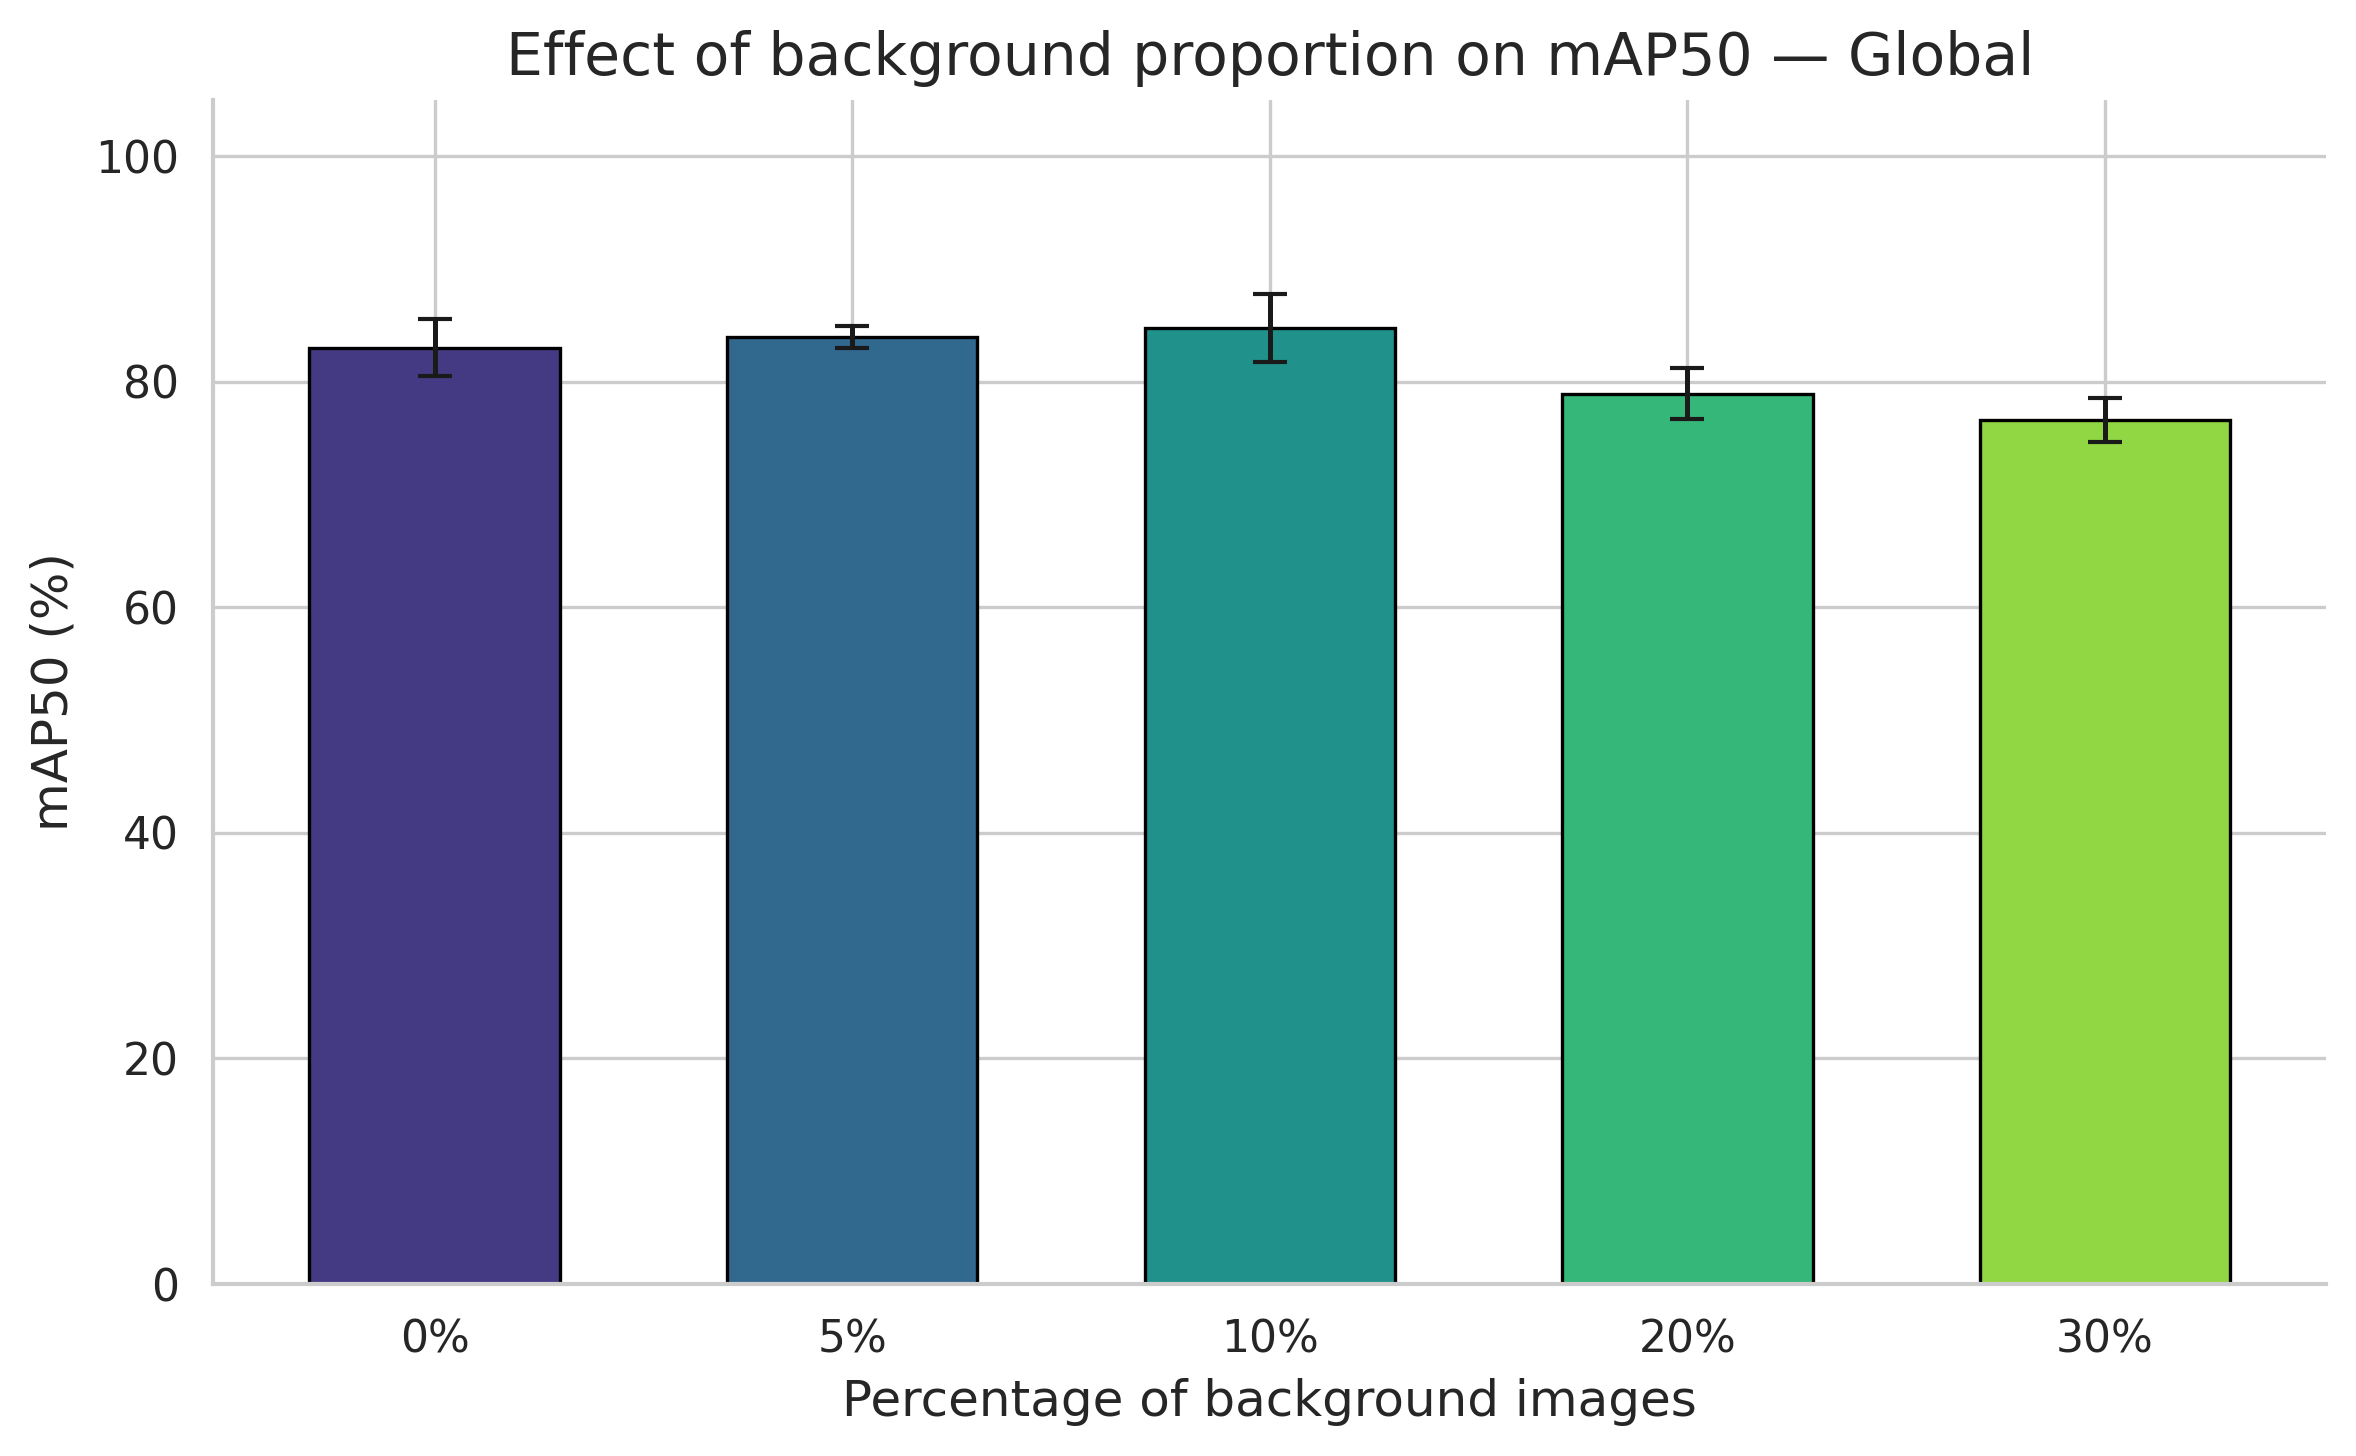

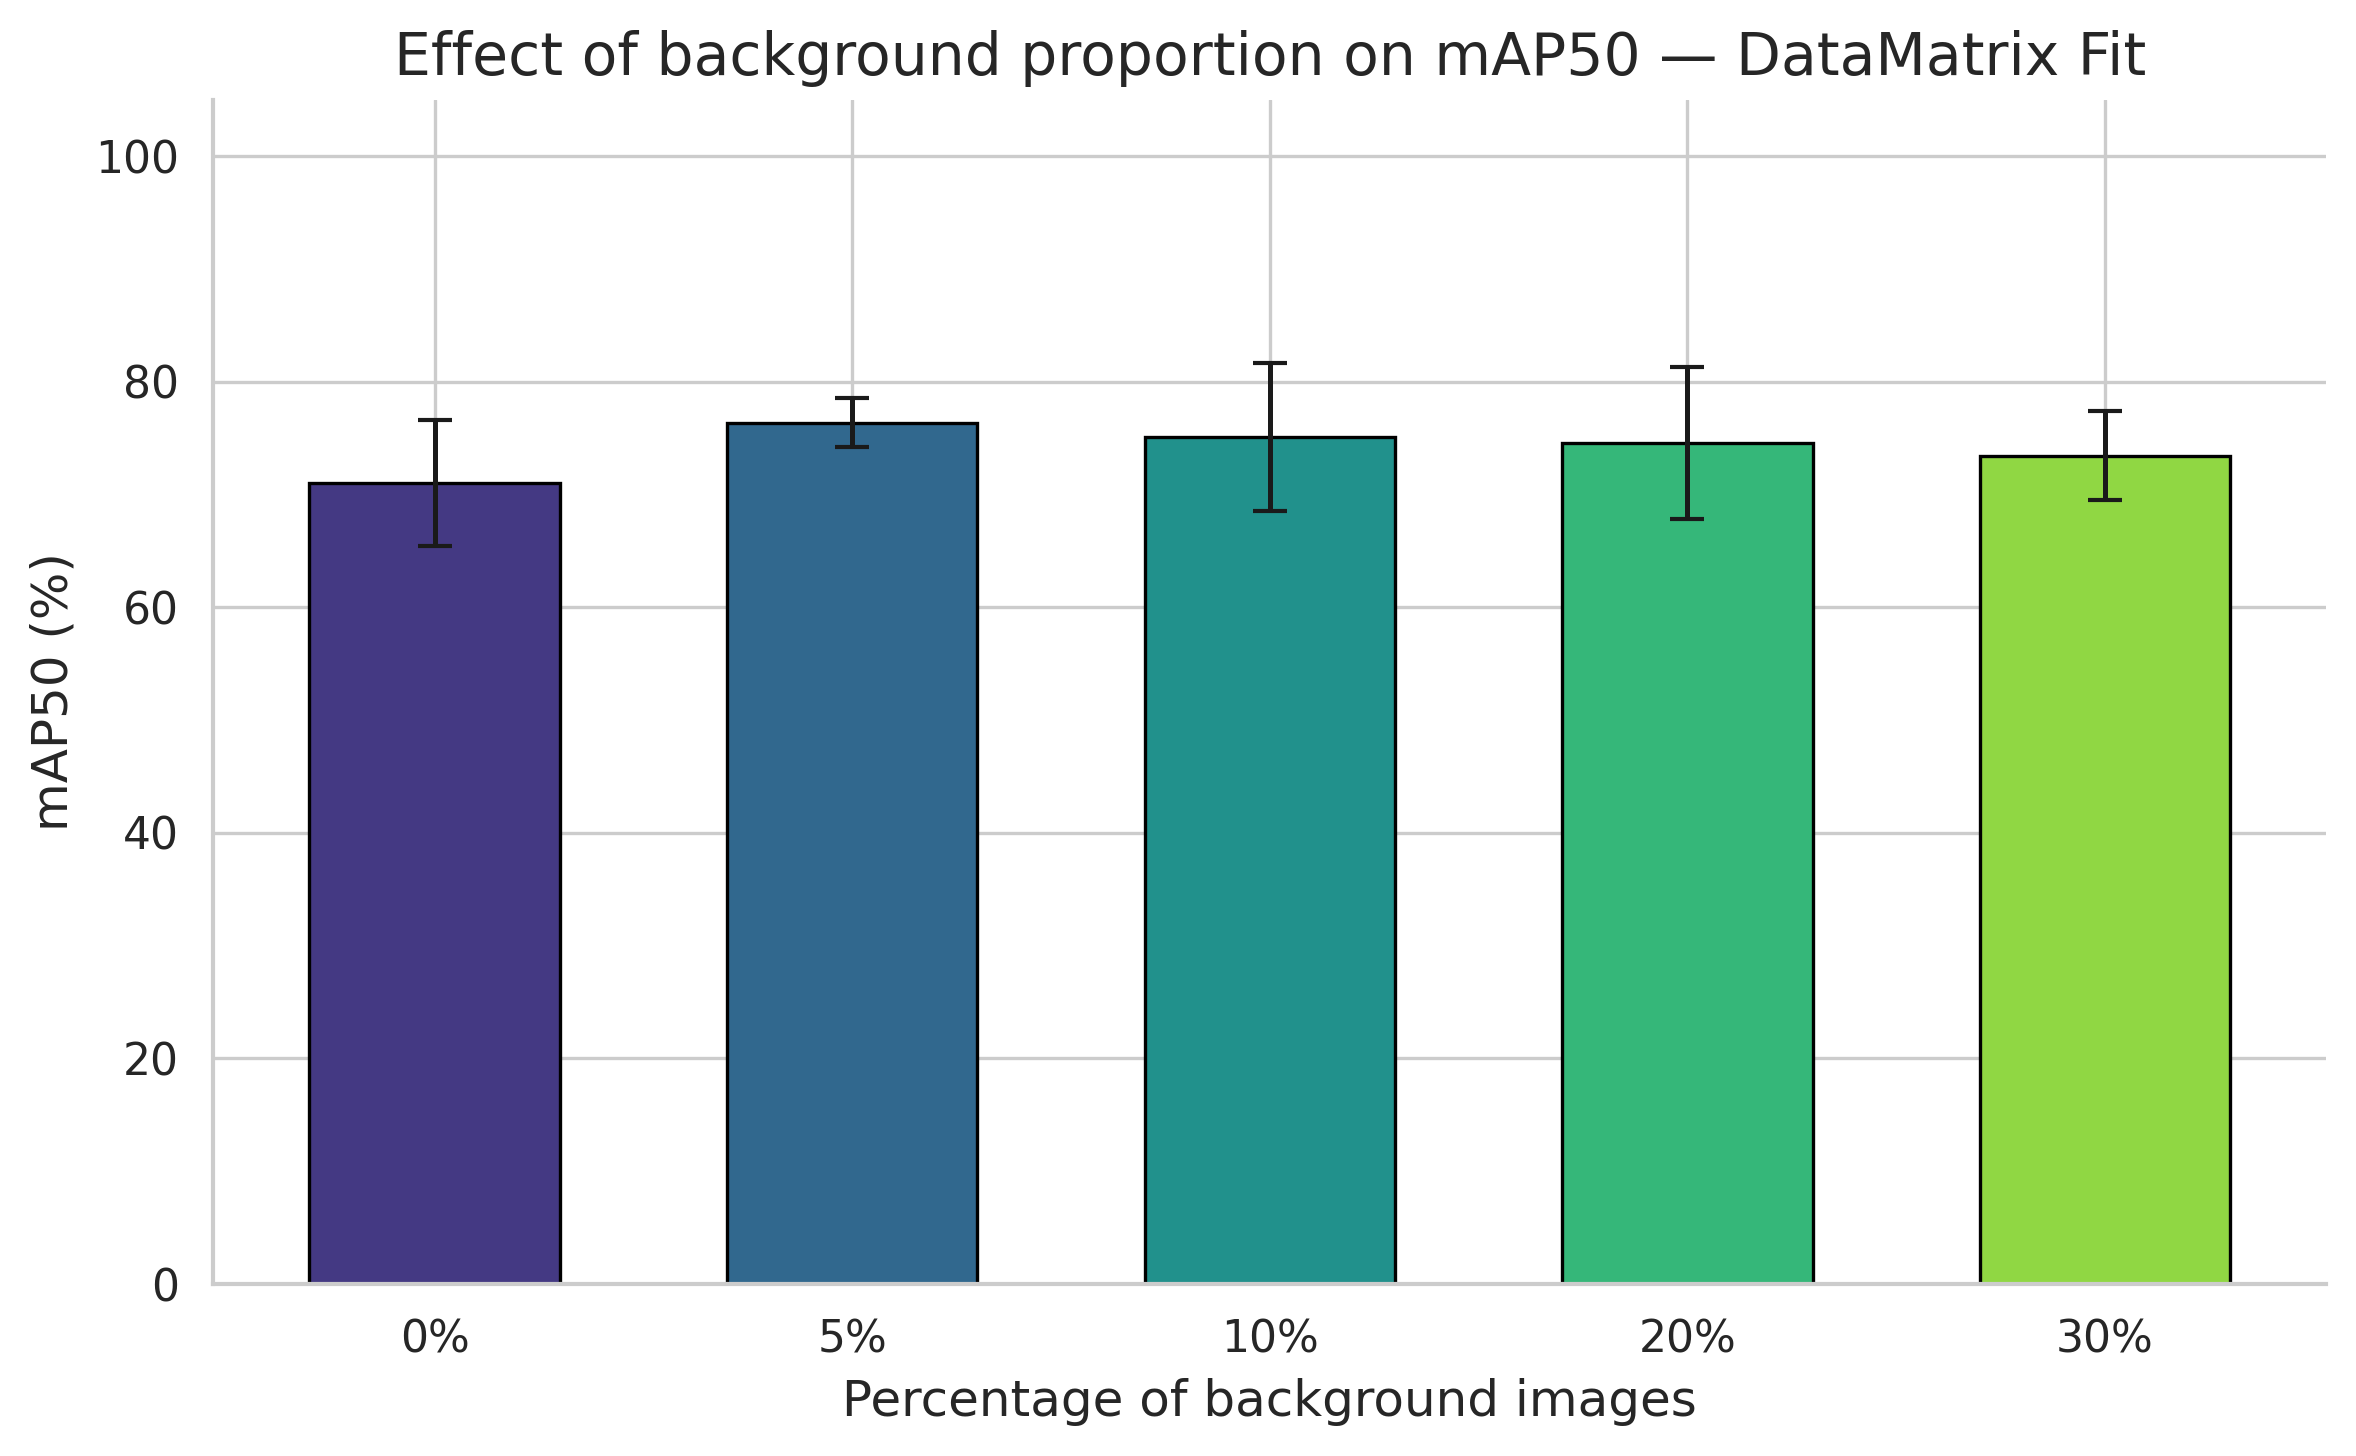

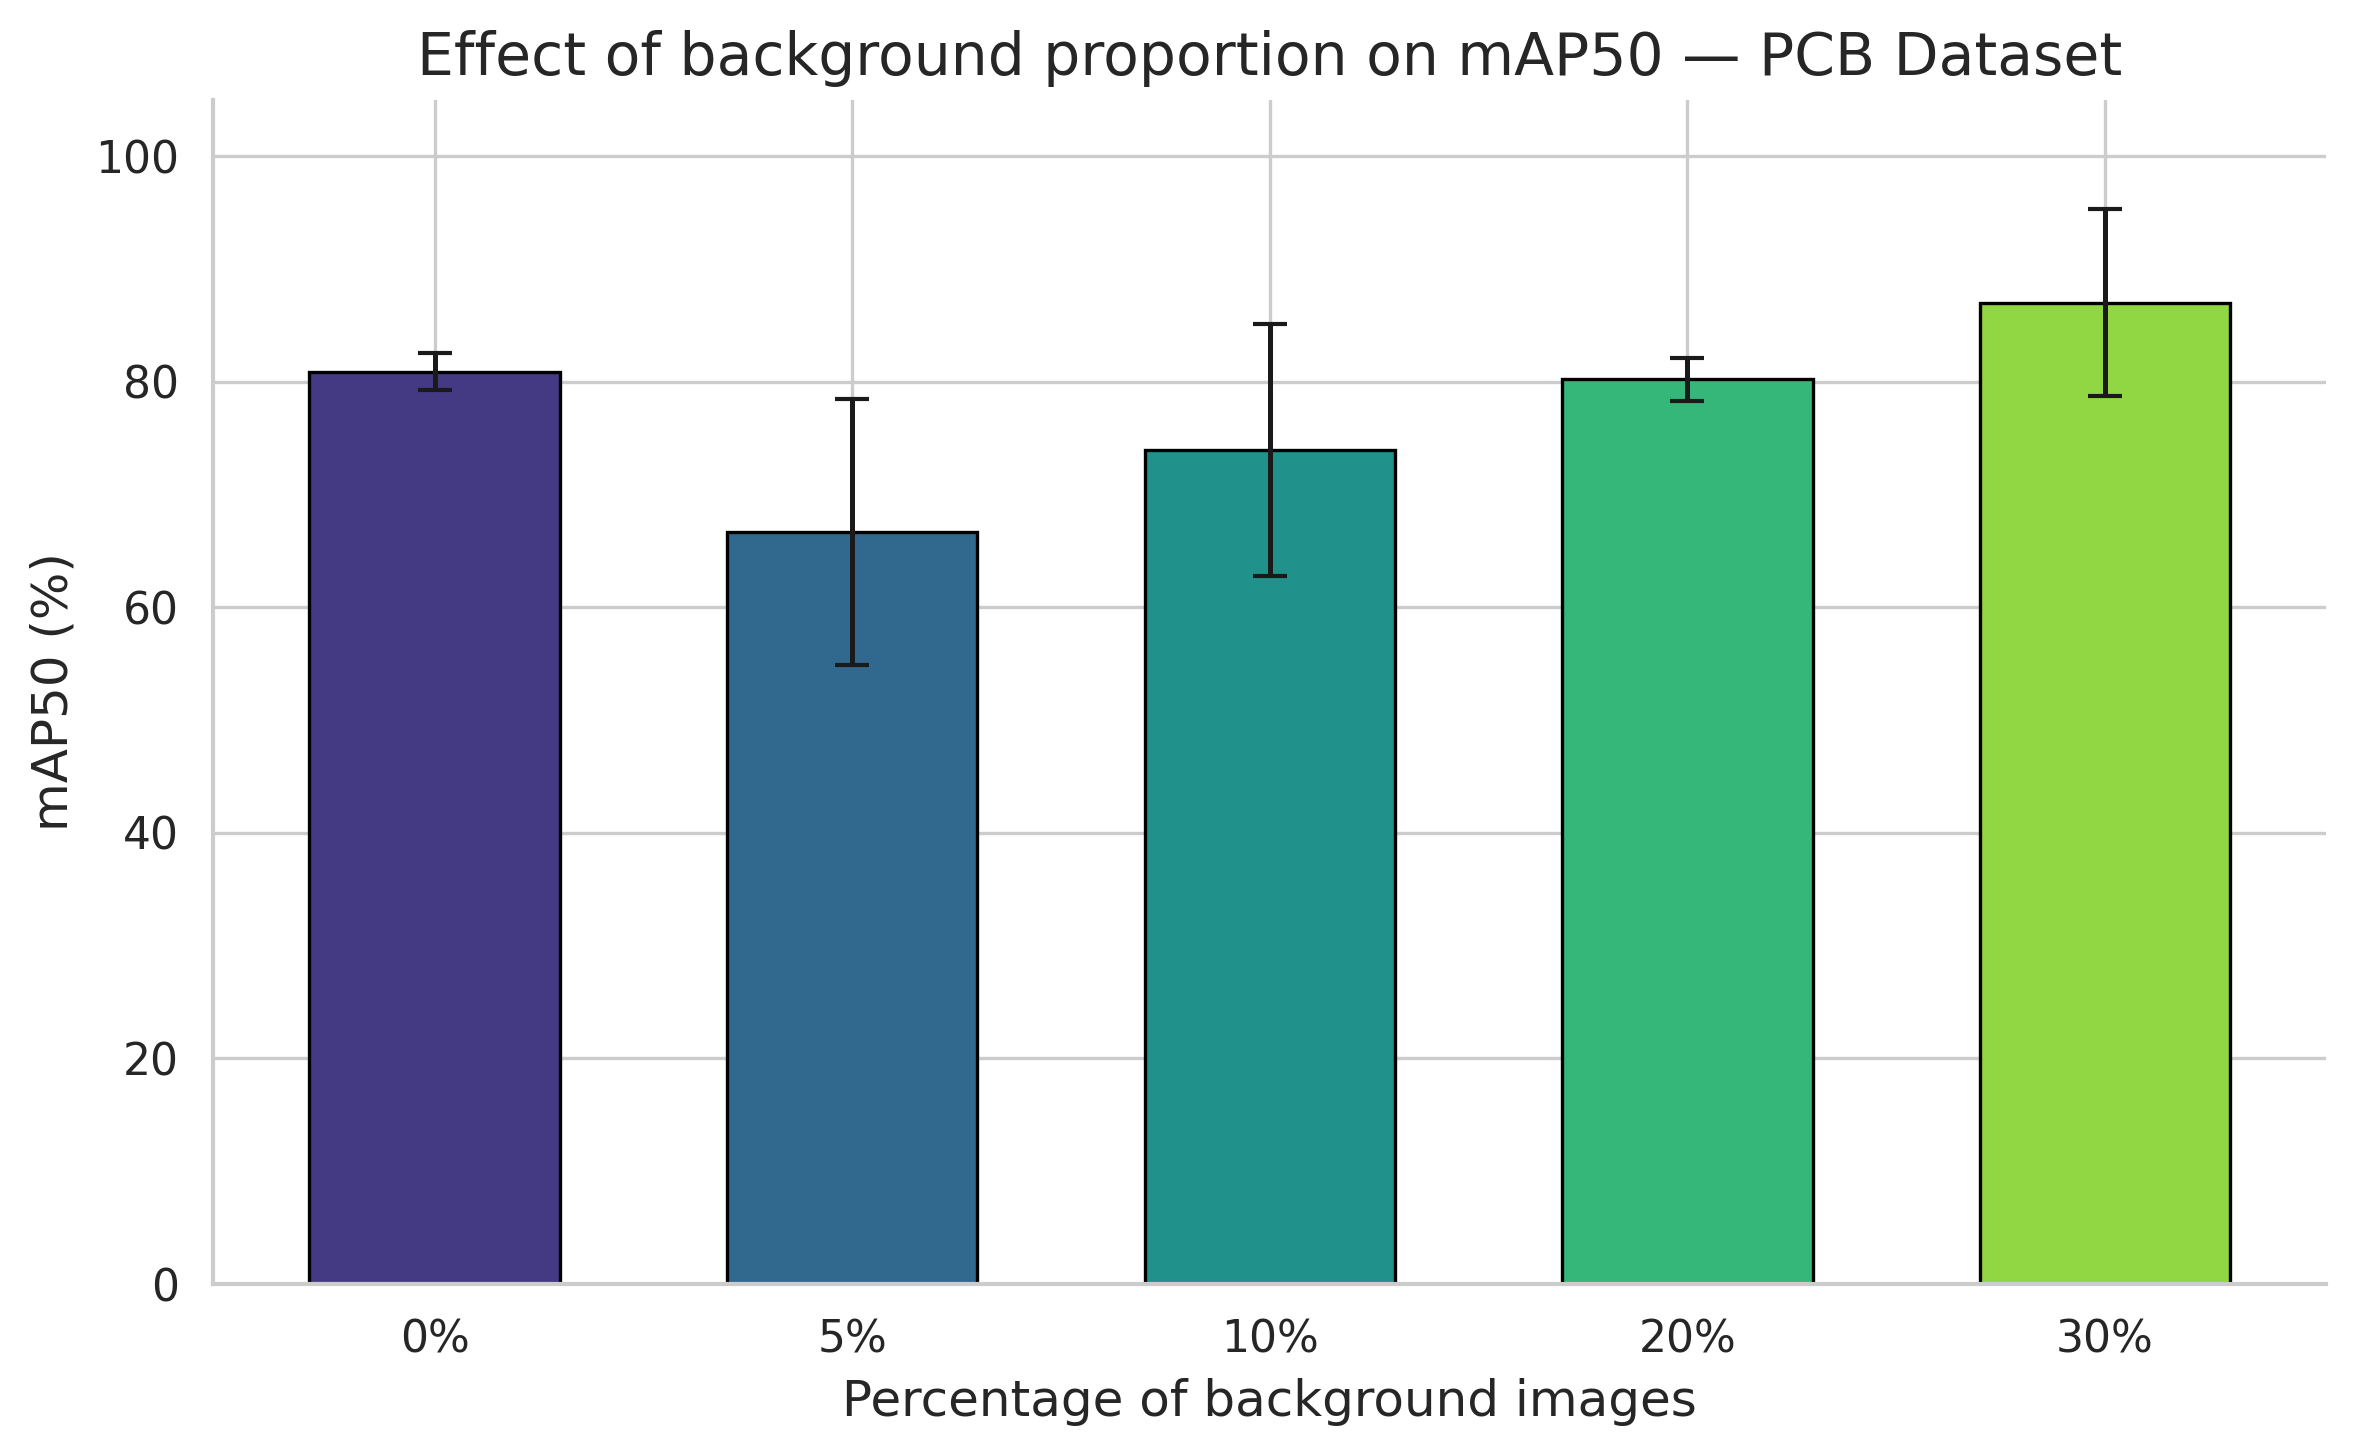

(    Background_%  mAP50_mean  mAP50_var
 8            0.0    0.830041   0.000646
 17           5.0    0.839488   0.000093
 26          10.0    0.847453   0.000908
 35          20.0    0.789421   0.000506
 44          30.0    0.766248   0.000378,
     Background_%  mAP50_mean  mAP50_var
 1            0.0    0.709984   0.003113
 10           5.0    0.763732   0.000466
 19          10.0    0.750914   0.004343
 28          20.0    0.745829   0.004553
 37          30.0    0.734048   0.001558,
     Background_%  mAP50_mean  mAP50_var
 4            0.0    0.808765   0.000264
 13           5.0    0.666893   0.013868
 22          10.0    0.739244   0.012494
 31          20.0    0.801981   0.000354
 40          30.0    0.869964   0.006855)

In [3]:
# Section 1 — mAP50 (bar chart with variance)

def plot_map50_for_source(source_name: str, display_name: str):
    """
    Plot mAP50 (mean ± variance) as a bar chart for a given source.
    Bars have equal spacing, thicker width and a scientific style.
    """
    df = agg_df[agg_df["Source"] == source_name].copy()
    df = df.sort_values("Background_%")

    if df.empty:
        print(f"No data found for source: {source_name}")
        return None

    # X positions equally spaced (categorical)
    x = np.arange(len(df))
    x_labels = [f"{int(b)}%" for b in df["Background_%"]]

    # mAP50 in percent + standard deviation from variance
    y = df["mAP50_mean"] * 100
    y_err = np.sqrt(df["mAP50_var"]) * 100

    # Color palette for bars
    colors = sns.color_palette("viridis", len(df))

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(
        x, y,
        yerr=y_err,
        capsize=4,
        width=0.6,                  # thicker bars
        color=colors,
        edgecolor="black",
        linewidth=0.8
    )

    ax.set_xlabel("Percentage of background images")
    ax.set_ylabel("mAP50 (%)")
    ax.set_title(f"Effect of background proportion on mAP50 — {display_name}")

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    ax.set_ylim(0, 105)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Return numeric values for traceability in the notebook
    return df[["Background_%", "mAP50_mean", "mAP50_var"]]


# --- Calls for the three requested datasets ---

global_map50_stats = plot_map50_for_source(
    "TestSet::global::global",
    "Global"
)

datamatrixfit_map50_stats = plot_map50_for_source(
    "TestSet::dataset::datamatrixfit",
    "DataMatrix Fit"
)

pcbdataset_map50_stats = plot_map50_for_source(
    "TestSet::dataset::pcbdataset",
    "PCB Dataset"
)

global_map50_stats, datamatrixfit_map50_stats, pcbdataset_map50_stats


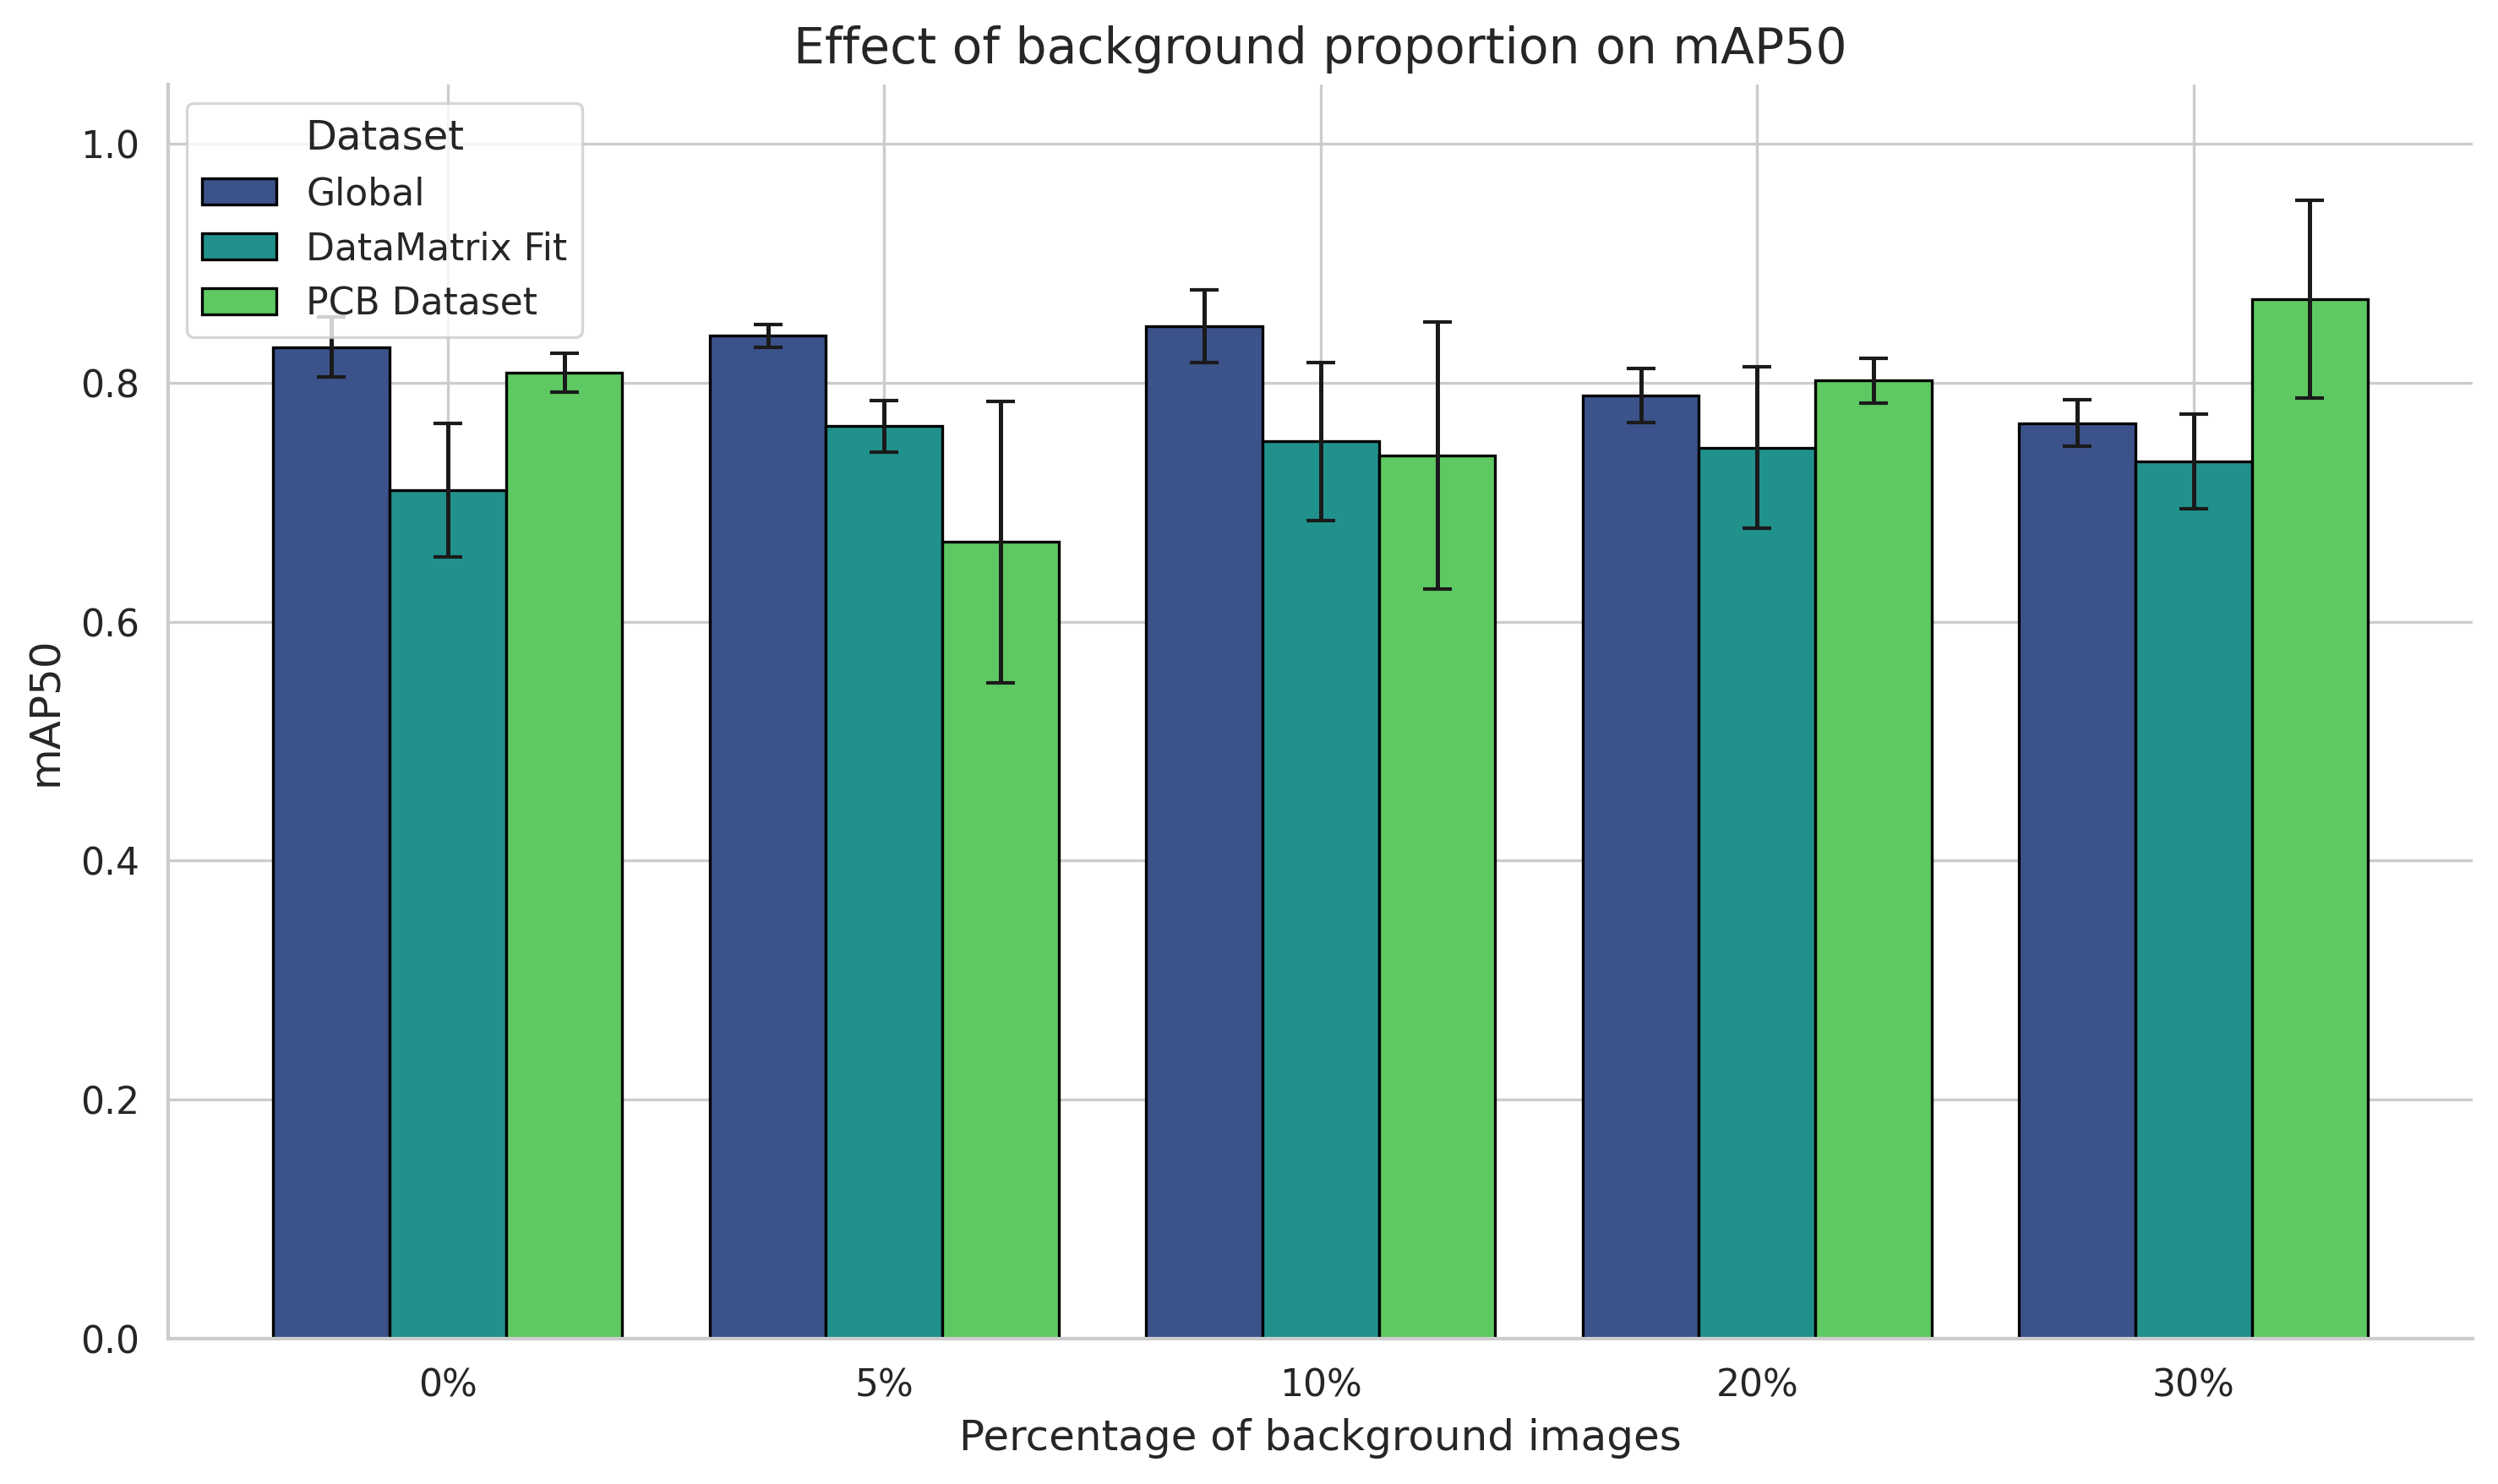

(Source        TestSet::dataset::datamatrixfit  TestSet::dataset::pcbdataset  \
 Background_%                                                                  
 0.0                                  0.709984                      0.808765   
 5.0                                  0.763732                      0.666893   
 10.0                                 0.750914                      0.739244   
 20.0                                 0.745829                      0.801981   
 30.0                                 0.734048                      0.869964   
 
 Source        TestSet::global::global  
 Background_%                           
 0.0                          0.830041  
 5.0                          0.839488  
 10.0                         0.847453  
 20.0                         0.789421  
 30.0                         0.766248  ,
 Source        TestSet::dataset::datamatrixfit  TestSet::dataset::pcbdataset  \
 Background_%                                                         

In [4]:
def plot_map50_combined(sources):
    """
    Plot combined mAP50 (mean ± variance) for multiple sources on one bar chart.
    - sources: list of (source_name, display_name)
    """
    source_names = [s[0] for s in sources]
    display_names = {s[0]: s[1] for s in sources}

    # Filtrer uniquement les sources d'intérêt
    df = agg_df[agg_df["Source"].isin(source_names)][
        ["Source", "Background_%", "mAP50_mean", "mAP50_var"]
    ].copy()

    if df.empty:
        print("No data found for the given sources.")
        return None

    # Pivot pour obtenir une table Background_% x Source
    pivot_mean = df.pivot(index="Background_%", columns="Source", values="mAP50_mean")
    pivot_var  = df.pivot(index="Background_%", columns="Source", values="mAP50_var")

    # Ordonner les backgrounds
    backgrounds = pivot_mean.index.values
    backgrounds_sorted = np.sort(backgrounds)

    pivot_mean = pivot_mean.loc[backgrounds_sorted]
    pivot_var  = pivot_var.loc[backgrounds_sorted]

    n_back = len(backgrounds_sorted)
    n_src = len(source_names)

    # Positions de groupes (un groupe par pourcentage de background)
    x = np.arange(n_back)

    group_width = 0.8
    bar_width = group_width / n_src

    fig, ax = plt.subplots(figsize=(10, 6))

    palette = sns.color_palette("viridis", n_src)

    for i, src in enumerate(source_names):
        # Position de ce dataset dans chaque groupe
        x_pos = x - group_width/2 + (i + 0.5) * bar_width

        y = pivot_mean[src]
        y_err = np.sqrt(pivot_var[src])

        ax.bar(
            x_pos, y,
            yerr=y_err,
            capsize=4,
            width=bar_width,
            color=palette[i],
            edgecolor="black",
            linewidth=0.8,
            label=display_names[src]
        )

    ax.set_xlabel("Percentage of background images")
    ax.set_ylabel("mAP50")
    ax.set_title("Effect of background proportion on mAP50")

    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(b)}%" for b in backgrounds_sorted])

    ax.set_ylim(0.0, 1.05)
    ax.legend(frameon=True, title="Dataset")

    sns.despine()
    plt.tight_layout()
    plt.show()

    # Renvoie les tableaux pour traçabilité
    return pivot_mean, pivot_var


# Appel combiné pour Global, DataMatrixFit et PCBDataset
combined_mean, combined_var = plot_map50_combined([
    ("TestSet::global::global",        "Global"),
    ("TestSet::dataset::datamatrixfit","DataMatrix Fit"),
    ("TestSet::dataset::pcbdataset",   "PCB Dataset"),
])

combined_mean, combined_var


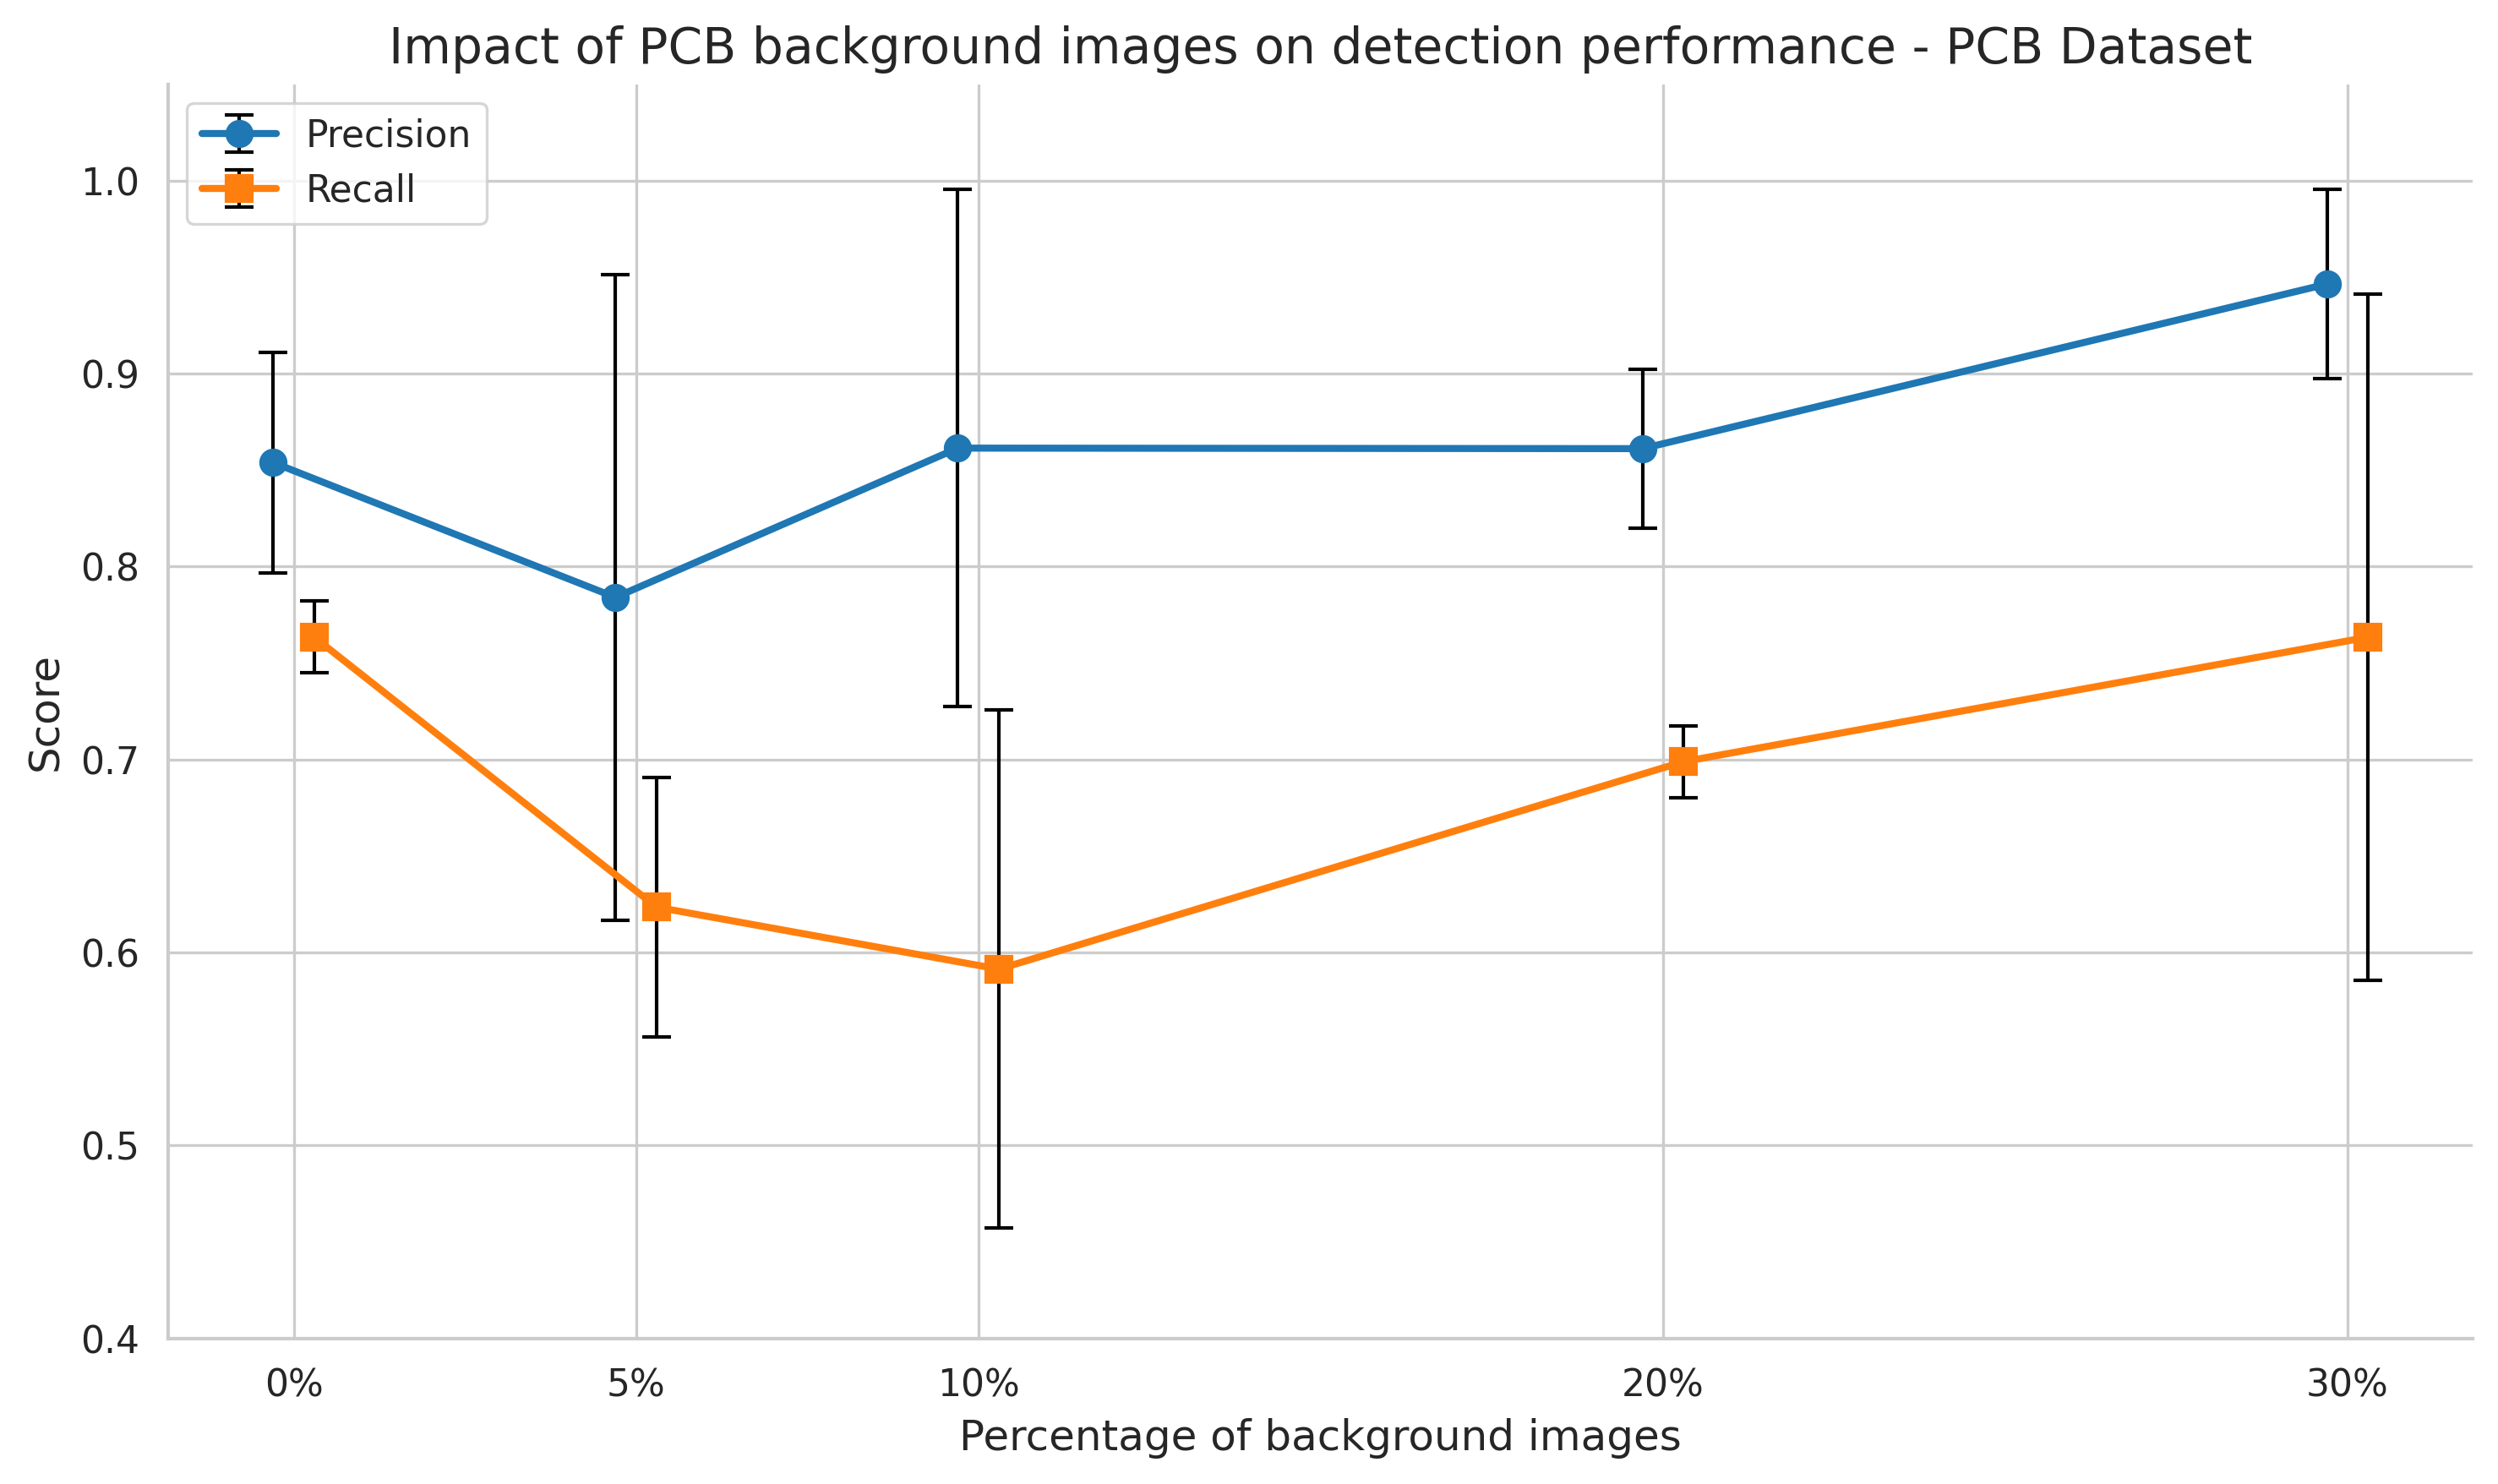

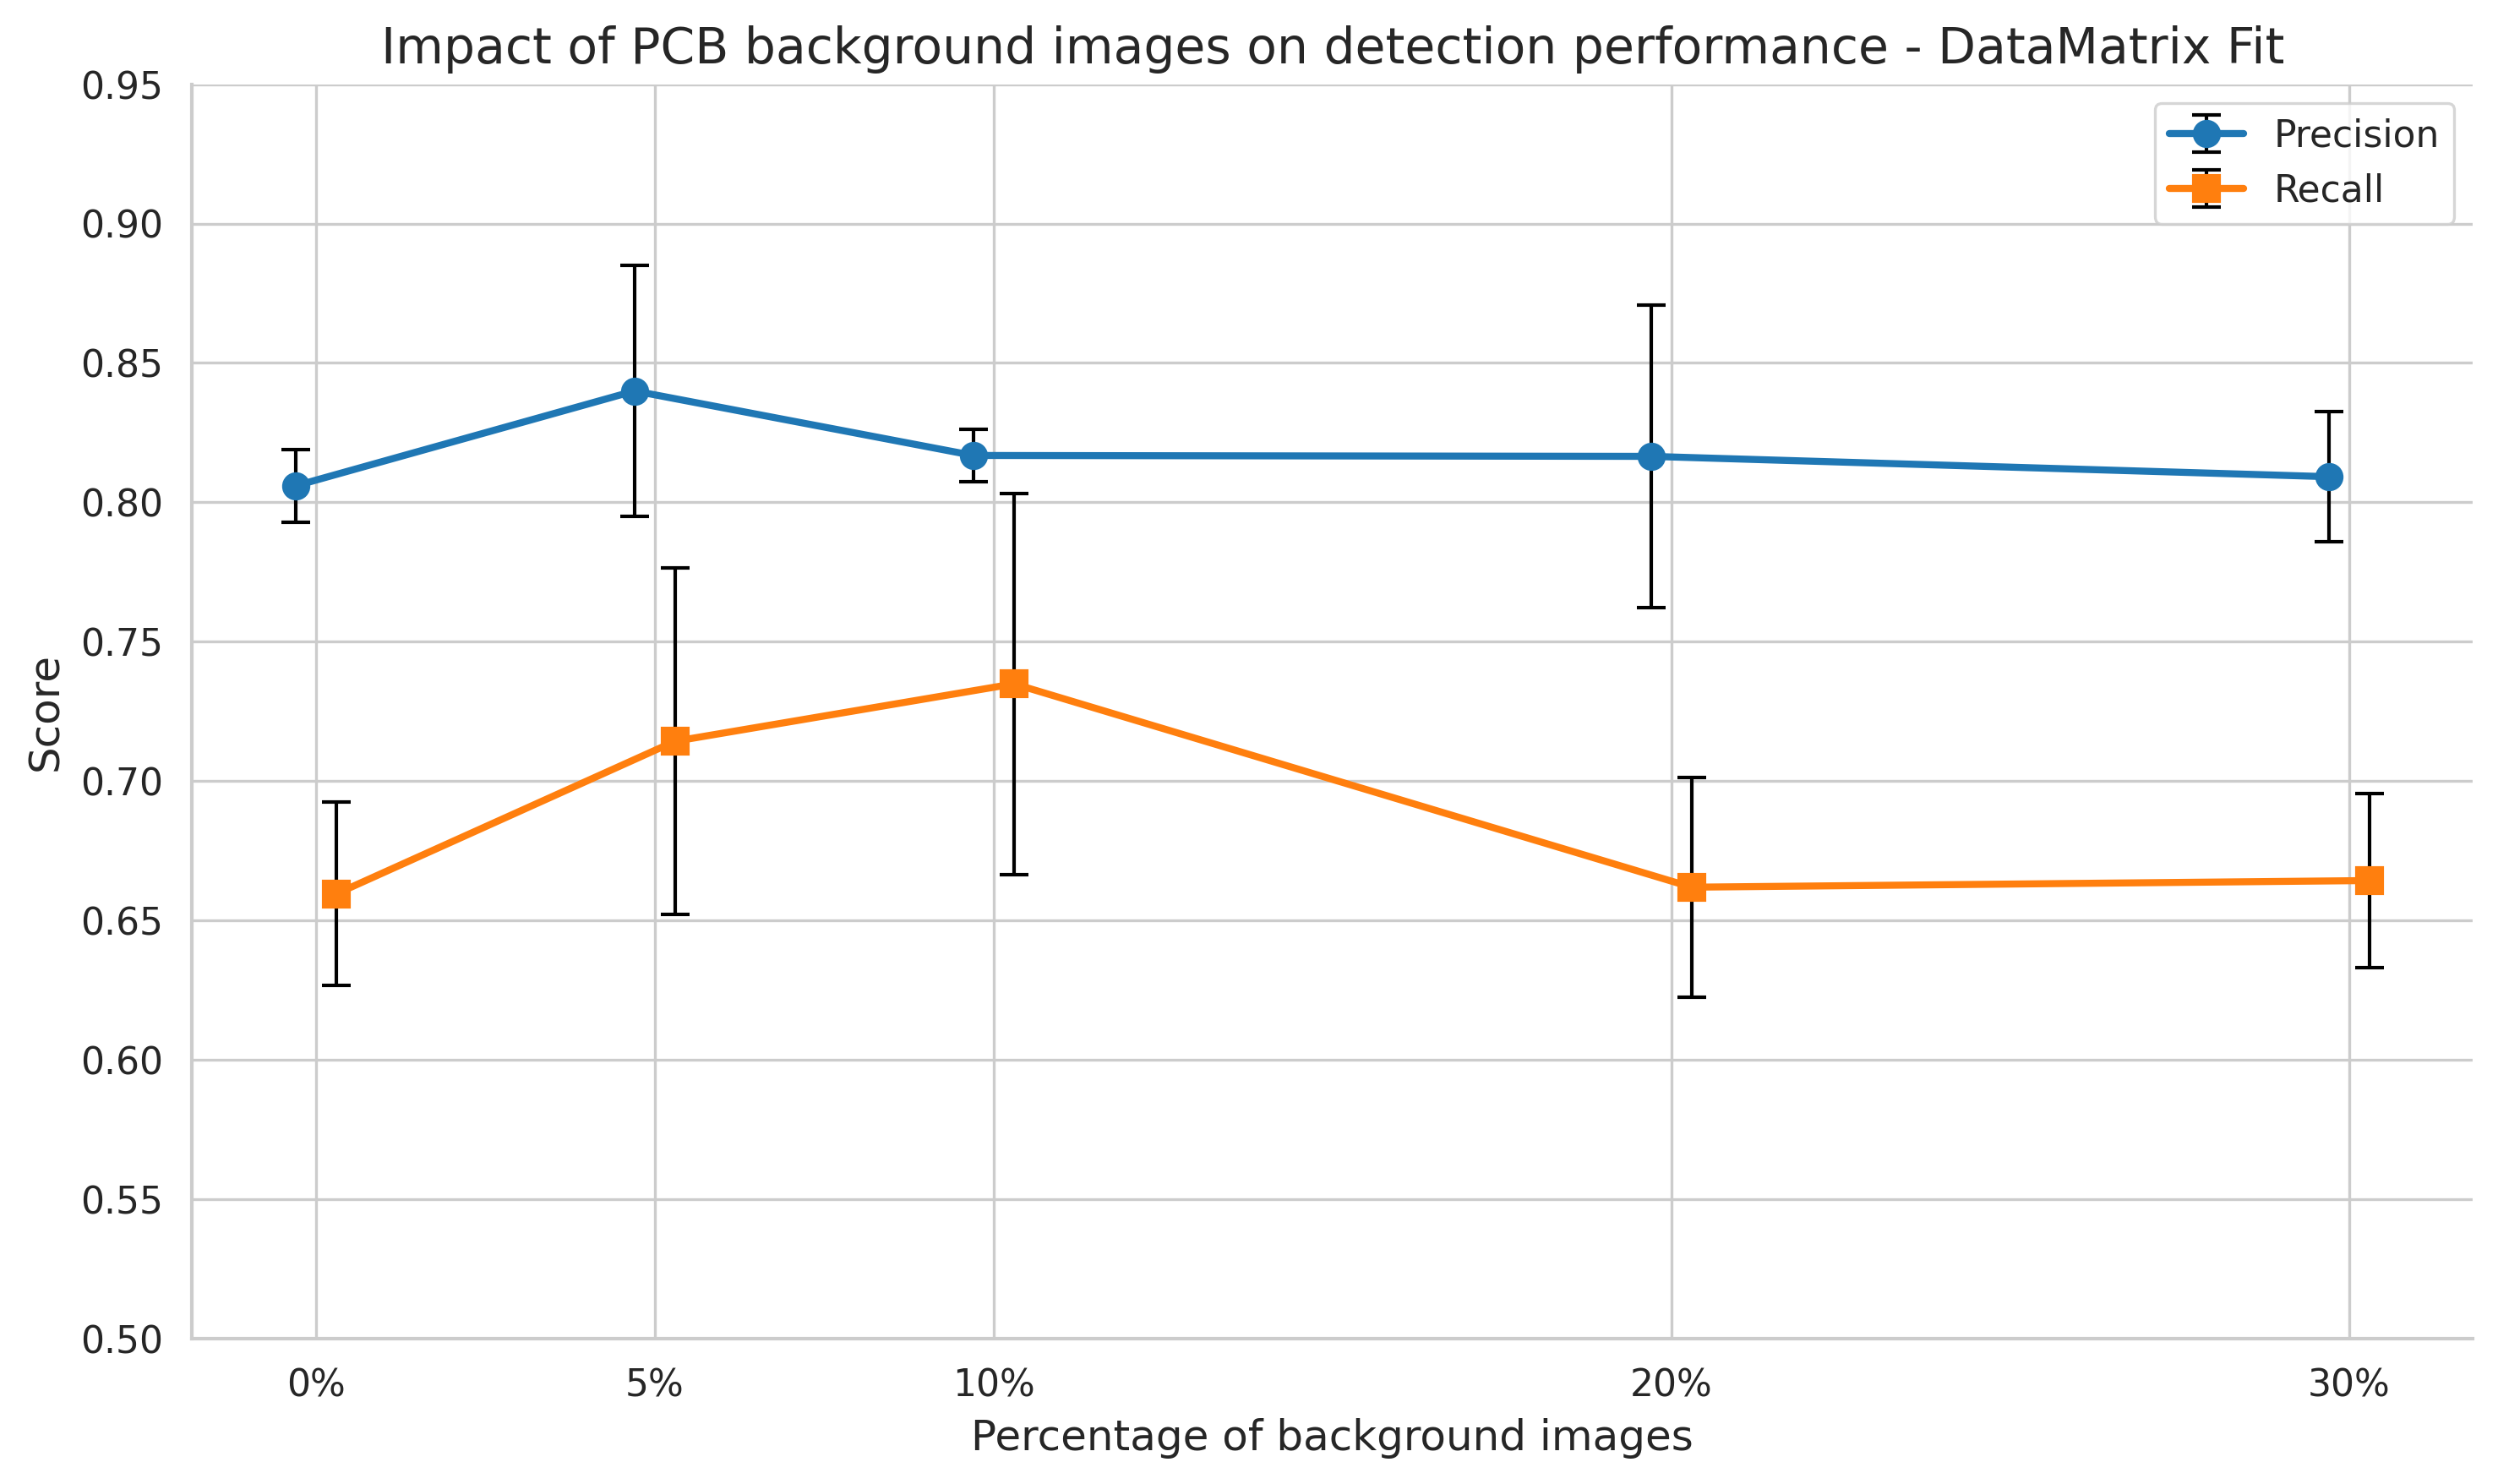

(    Background_%                        Source  mAP50-95_mean  mAP50-95_var  \
 4            0.0  TestSet::dataset::pcbdataset       0.511275      0.000048   
 13           5.0  TestSet::dataset::pcbdataset       0.405631      0.002926   
 22          10.0  TestSet::dataset::pcbdataset       0.453253      0.003807   
 31          20.0  TestSet::dataset::pcbdataset       0.476096      0.000242   
 40          30.0  TestSet::dataset::pcbdataset       0.535165      0.001087   
 
     mAP50_mean  mAP50_var  mAP75_mean  mAP75_var  Precision_mean  \
 4     0.808765   0.000264    0.572156   0.000342        0.853928   
 13    0.666893   0.013868    0.493649   0.003461        0.784072   
 22    0.739244   0.012494    0.545983   0.003609        0.861416   
 31    0.801981   0.000354    0.572671   0.000627        0.861145   
 40    0.869964   0.006855    0.610781   0.001724        0.946460   
 
     Precision_var  ...  Inference Time (ms)_mean  Inference Time (ms)_var  \
 4        0.003274  ... 

In [ ]:
def plot_precision_recall_for_dataset(source_name: str, display_name: str):
    df = agg_df[agg_df["Source"] == source_name].copy()
    df = df.sort_values("Background_%")

    x = df["Background_%"].values.astype(float)

    # Décalage sur l'axe X
    offset = 0.3
    x_prec = x - offset
    x_rec = x + offset

    prec = df["Precision_mean"]
    rec = df["Recall_mean"]
    prec_err = np.sqrt(df["Precision_var"])
    rec_err = np.sqrt(df["Recall_var"])

    fig, ax = plt.subplots(figsize=(10, 6))

    # Precision avec décalage
    ax.errorbar(
        x_prec, prec, yerr=prec_err,
        marker="o", markersize=7,
        linestyle="-", linewidth=2,
        color="#1f77b4",
        ecolor="black", elinewidth=1, capsize=4,
        label="Precision"
    )

    # Recall avec décalage
    ax.errorbar(
        x_rec, rec, yerr=rec_err,
        marker="s", markersize=7,
        linestyle="-", linewidth=2,
        color="#ff7f0e",
        ecolor="black", elinewidth=1, capsize=4,
        label="Recall"
    )

    # Mise en forme
    ax.set_xlabel("Configuration")
    ax.set_ylabel("Score")
    ax.set_title(f"Impact of PCB background images on detection performance - {display_name}")

    ax.set_xticks(x)
    x_labels = ["MS", "BG5", "BG10", "BG20", "BG30"]
    ax.set_xticklabels(x_labels)
    if "datamatrix" in source_name:
        ax.set_ylim(0.5, 0.95)
    else:
        ax.set_ylim(0.4, 1.05)
    ax.legend(frameon=True)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"precision_recall_{source_name.replace('::', '_')}.png")
    plt.show()

    return df



# 2 graphiques pour pcbdataset et datamatrixfit
pcbdataset_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::pcbdataset",
    "PCB Dataset"
)

datamatrixfit_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::datamatrixfit",
    "DataMatrix Fit"
)

pcbdataset_stats, datamatrixfit_stats


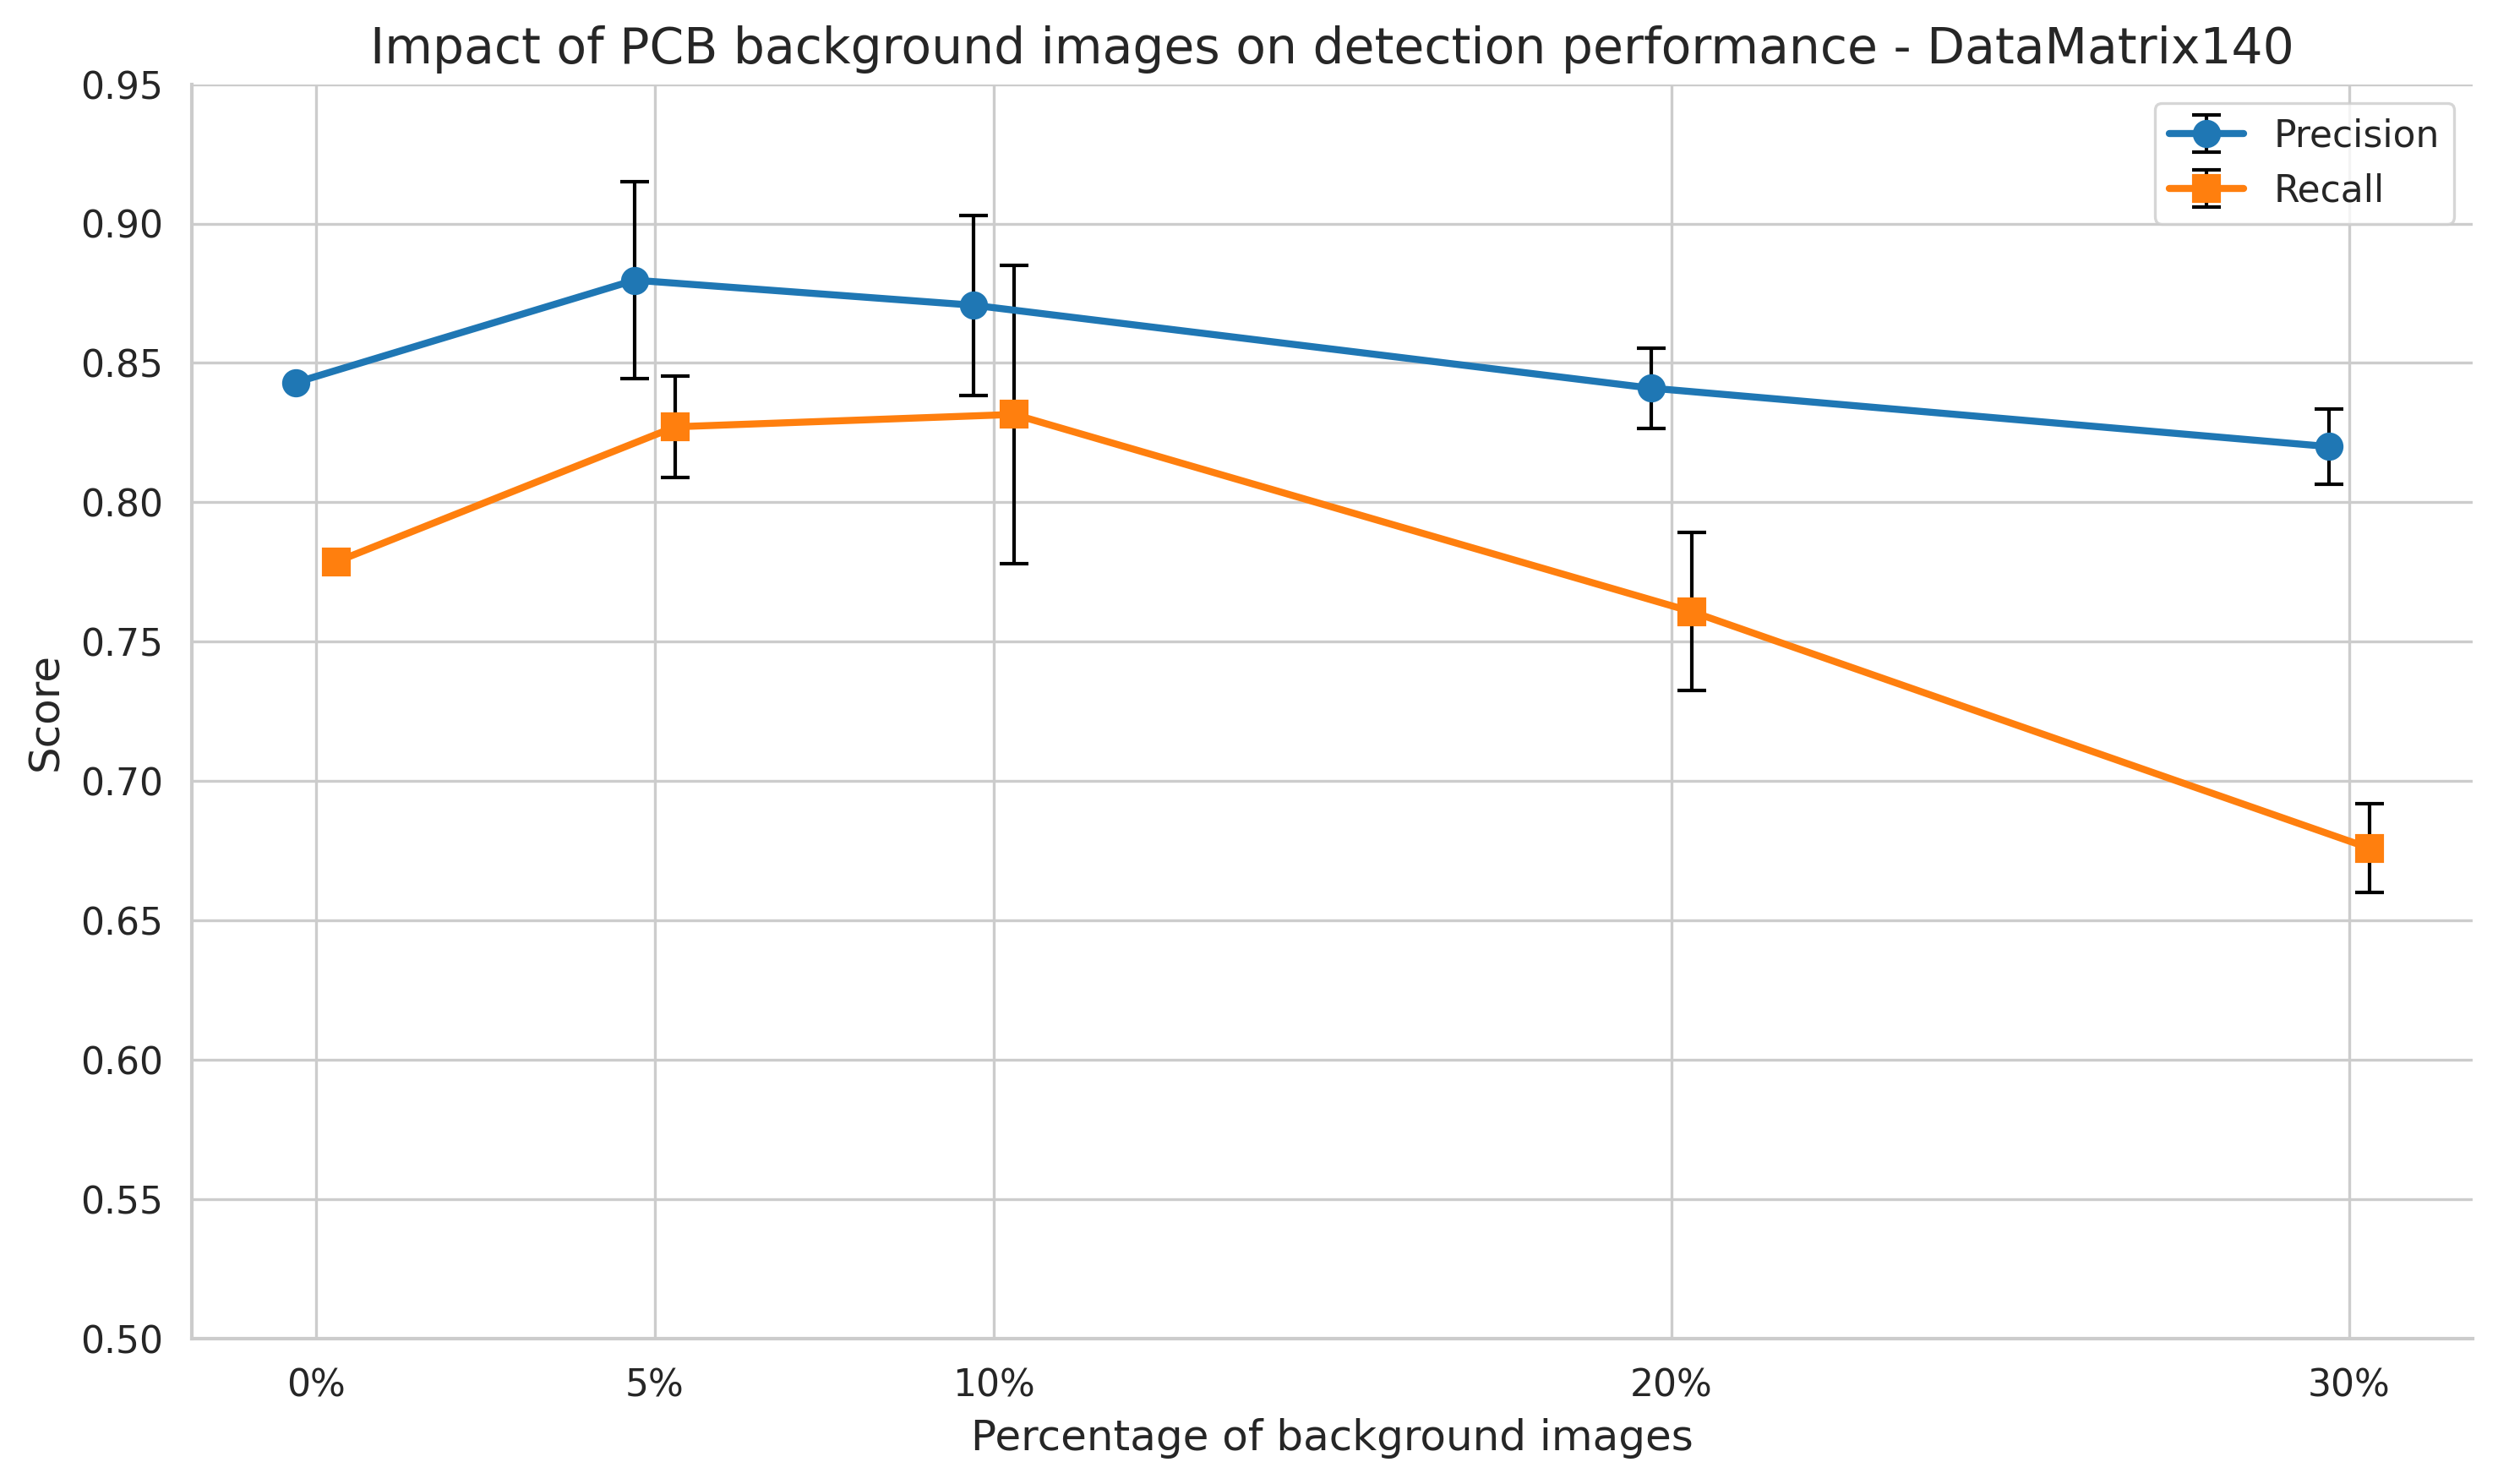

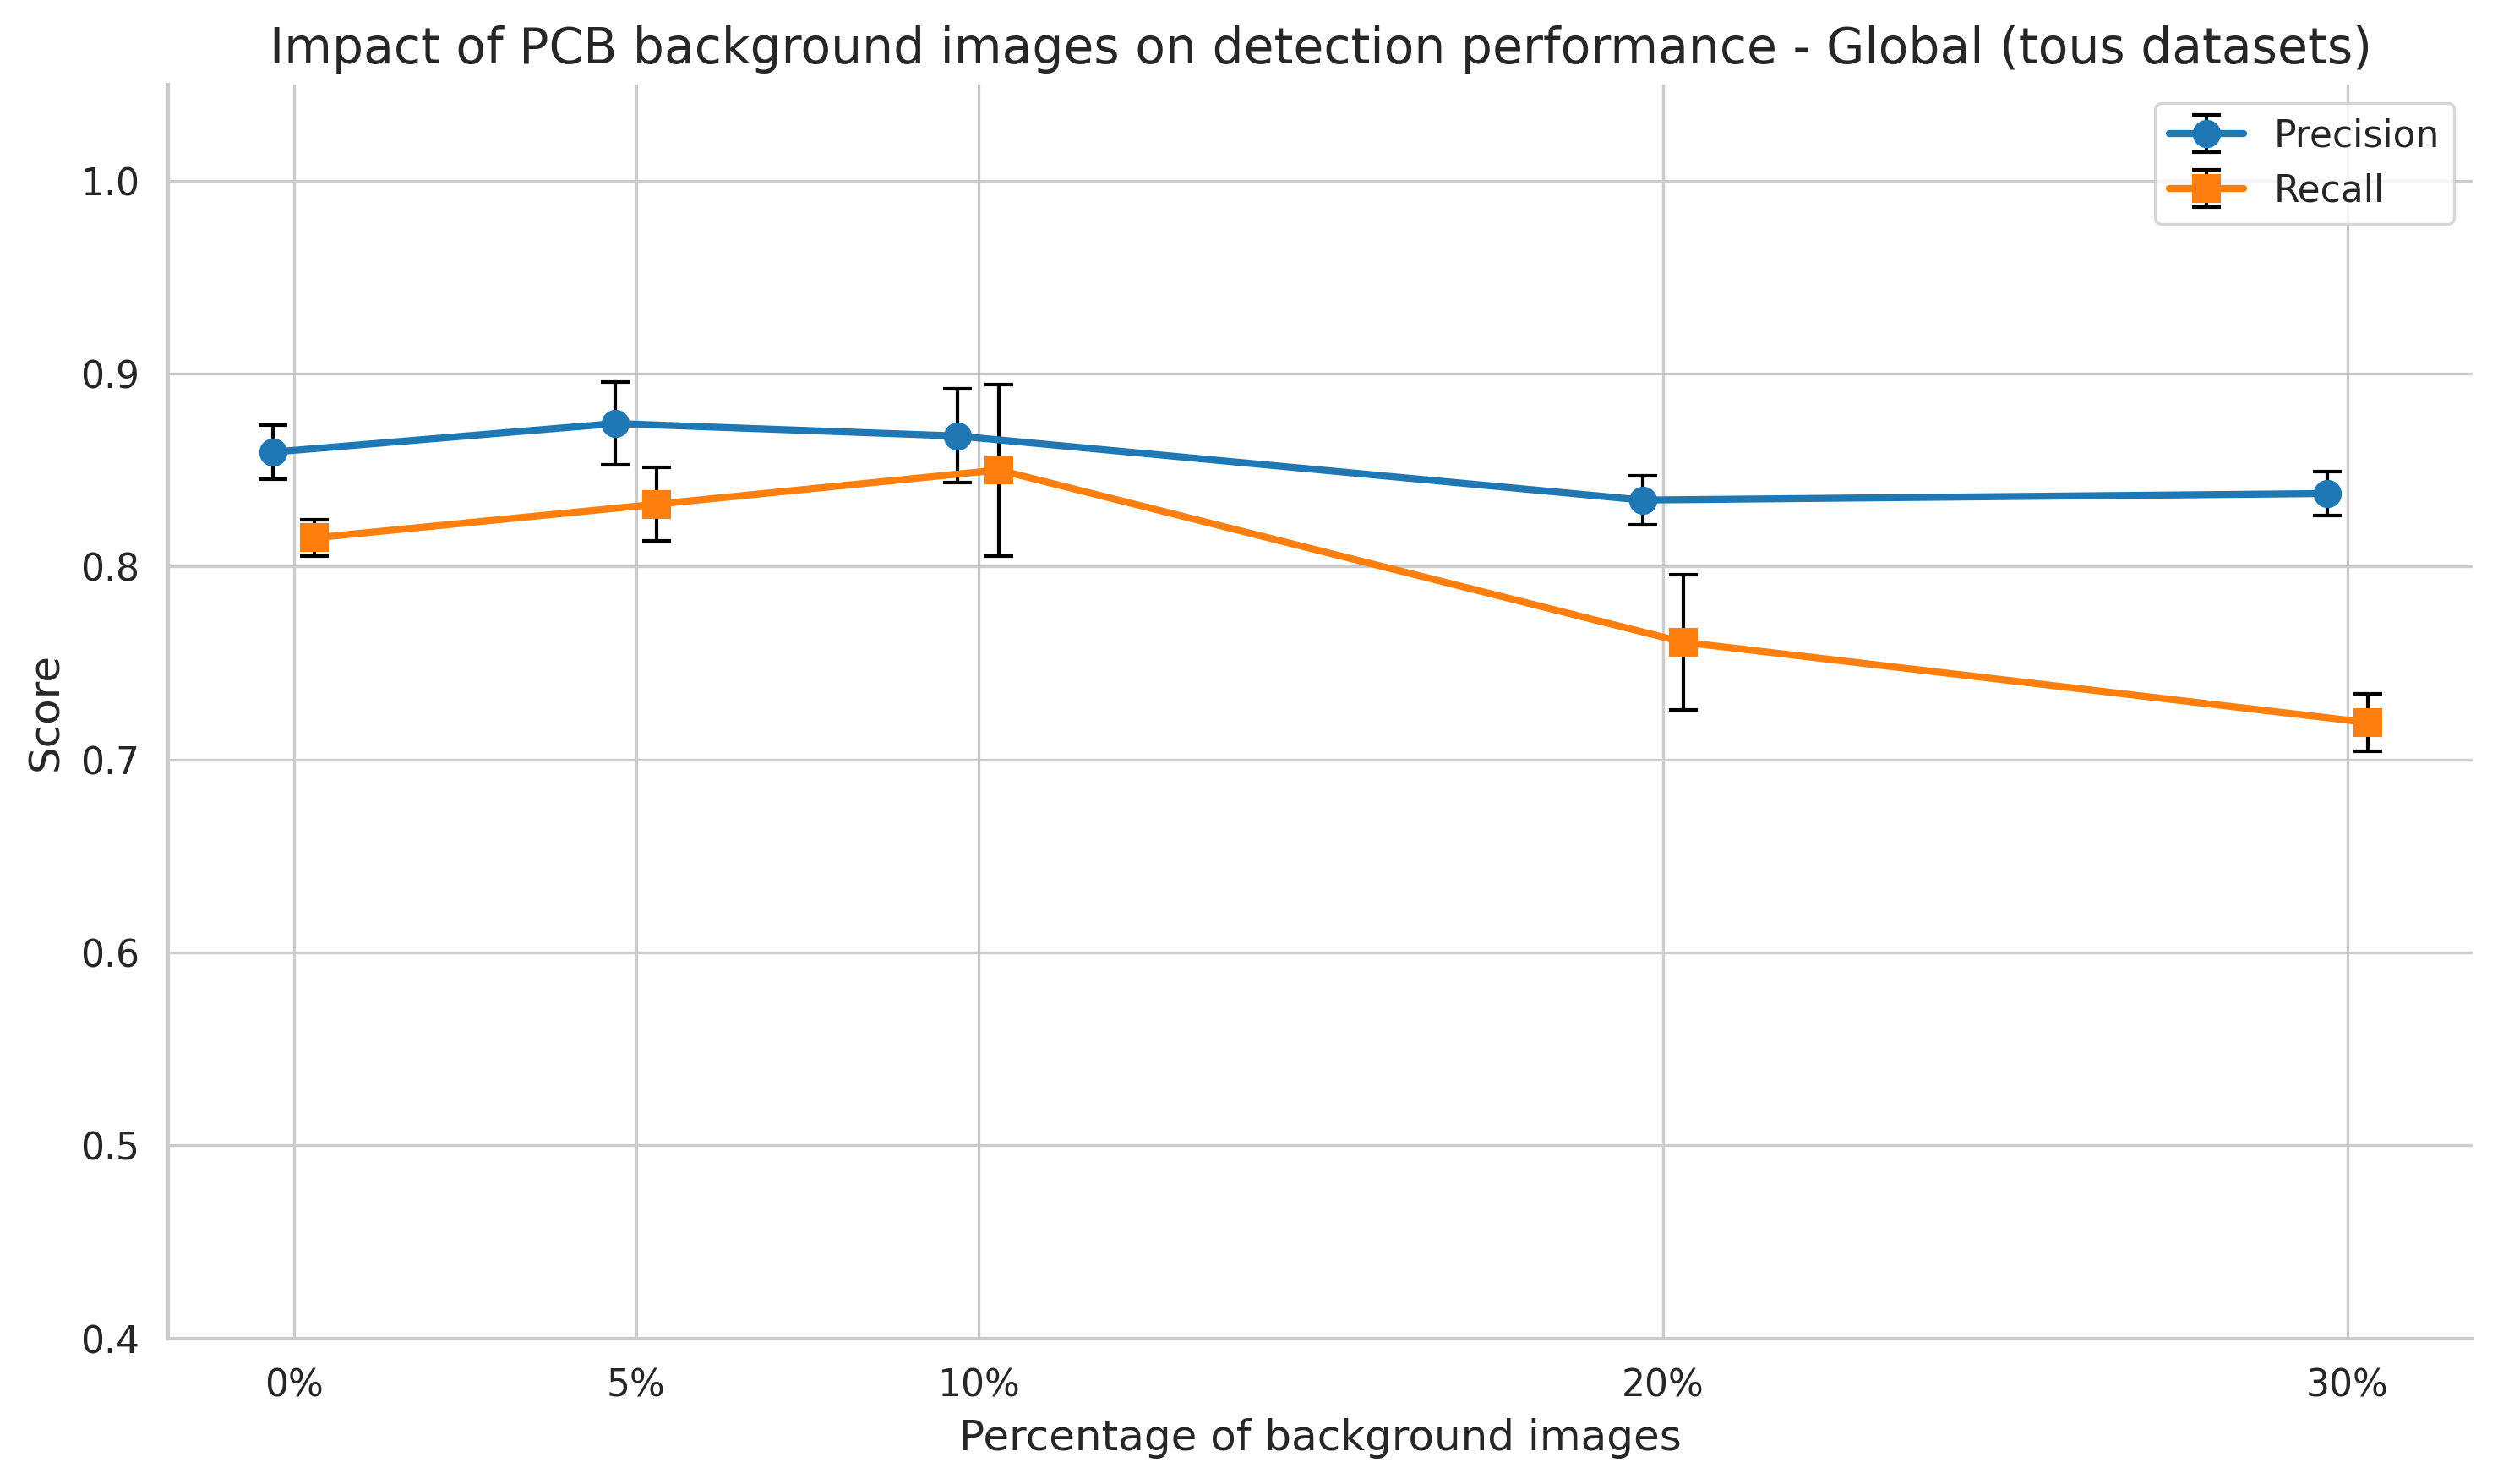

(    Background_%                           Source  mAP50-95_mean  \
 0            0.0  TestSet::dataset::datamatrix140       0.306632   
 9            5.0  TestSet::dataset::datamatrix140       0.382069   
 18          10.0  TestSet::dataset::datamatrix140       0.368627   
 27          20.0  TestSet::dataset::datamatrix140       0.311107   
 36          30.0  TestSet::dataset::datamatrix140       0.282529   
 
     mAP50-95_var  mAP50_mean  mAP50_var  mAP75_mean  mAP75_var  \
 0            NaN    0.771544        NaN    0.191722        NaN   
 9       0.002044    0.827220   0.000372    0.304285   0.006011   
 18      0.002715    0.822823   0.002054    0.277575   0.005254   
 27      0.000320    0.761915   0.000610    0.201888   0.000338   
 36      0.000349    0.718086   0.000535    0.173371   0.000386   
 
     Precision_mean  Precision_var  ...  Inference Time (ms)_mean  \
 0         0.842951            NaN  ...                 26.421956   
 9         0.879698       0.001245  ...   

In [6]:
# Section 3 — Precision & Recall pour datamatrix140 et global

datamatrix140_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::datamatrix140",
    "DataMatrix140"
)

global_pr_stats = plot_precision_recall_for_dataset(
    "TestSet::global::global",
    "Global (tous datasets)"
)

datamatrix140_stats, global_pr_stats
